In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# no data augmentation
df_noda = pd.read_csv("evaluation/metrics_seg_noda.csv")
# with data augmentation
df_da = pd.read_csv("evaluation/metrics_seg_da_8s.csv")

# Add an experiment column to distinguish between datasets
df_da["Experiment"] = "With DA"
df_noda["Experiment"] = "Without DA"


# convert str of lists in df to list
def str_to_list(x):
    return [float(i) for i in x.strip("[]").split(",")]

# ---------------------
# Matplotlib Customization
# ---------------------
# Enable LaTeX rendering for text
mpl.rcParams['text.usetex'] = True
# Use a serif font (e.g., Computer Modern)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman']
# Adjust default font size for publication-quality figures
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12

# Optional: tweak grid and tick appearance for a clean, scientific look
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.color'] = '0.75'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

# ---------------------
# Seaborn Customization
# ---------------------
# Use a context suited for papers (scaling fonts and elements)
sns.set_context("paper", font_scale=1.2)
# Use a whitegrid style (you can experiment with "ticks" or "white" for a different look)
sns.set_style("whitegrid")

# Combine the dataframes
df = pd.concat([df_da, df_noda], ignore_index=True)

for col in [
    "train/box_loss",
    "train/seg_loss",
    "train/cls_loss",
    "val/box_loss",
    "val/seg_loss",
    "val/cls_loss",
]:
    df[col] = df[col].apply(str_to_list)

# Rename columns for clarity in the plots
rename_dict = {
    "precision(B)": "Precision (Box)",
    "recall(B)": "Recall (Box)",
    "mAP50(B)": "mAP50 (Box)",
    "mAP50-95(B)": "mAP50-95 (Box)",
    "precision(M)": "Precision (Mask)",
    "recall(M)": "Recall (Mask)",
    "mAP50(M)": "mAP50 (Mask)",
    "mAP50-95(M)": "mAP50-95 (Mask)",
    "speed_preprocess": "Preprocess Time (ms)",
    "speed_inference": "Inference Time (ms)",
    "speed_postprocess": "Postprocess Time (ms)",
    "train/box_loss": "Train Box Loss",
    "train/seg_loss": "Train Seg Loss",
    "train/cls_loss": "Train Class Loss",
    "val/box_loss": "Val Box Loss",
    "val/seg_loss": "Val Seg Loss",
    "val/cls_loss": "Val Class Loss",
}

df.rename(columns=rename_dict, inplace=True)

In [37]:
# =============================================================================
# Helper Functions for Filtering
# =============================================================================
def filter_by_data_aug(df, data_aug_flag):
    """
    Filter the dataframe based on the data augmentation flag.

    Parameters:
      - df: the full dataframe.
      - data_aug_flag: True (only models with DA: "With DA"),
                       False (only models without DA: "Without DA"), or
                       None (use all data).

    Returns:
      Filtered DataFrame.
    """
    if data_aug_flag is None:
        return df.copy()
    experiment_val = 'With DA' if data_aug_flag else 'Without DA'
    return df[df['Experiment'] == experiment_val].copy()

# =============================================================================
# Plotting Functions
# =============================================================================
def plot_metric_bar(df, metric, data_aug_flag=None, sort_by_metric=False, figsize=(10,6)):
    """
    Create a bar plot comparing a single numeric metric across models.

    Parameters:
      - df: DataFrame with your metrics.
      - metric: Column name for the metric (e.g., "Precision (Box)").
      - data_aug_flag: True/False/None for filtering.
      - sort_by_metric: if True, sort models by metric value.
      - figsize: size of the figure.
    """
    df_plot = filter_by_data_aug(df, data_aug_flag)
    if sort_by_metric:
        df_plot = df_plot.sort_values(metric, ascending=False)

    plt.figure(figsize=figsize)
    ax = sns.barplot(x='model', y=metric, data=df_plot)
    ax.set_title(f'Comparison of {metric} across YOLO Models')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
def plot_loss_curve(df, loss_column, data_aug_flag=None, figsize=(10,6)):
    """
    Plot the evolution of a loss metric over epochs.
    Assumes the loss column contains a list of loss values per row.

    Parameters:
      - df: DataFrame with your metrics.
      - loss_column: Column name for the loss (e.g., "Train Box Loss").
      - data_aug_flag: True/False/None for filtering.
      - figsize: size of the figure.
    """
    df_plot = filter_by_data_aug(df, data_aug_flag)

    # Convert each row's list of losses to long format.
    loss_data = []
    min_loss = []
    for _, row in df_plot.iterrows():
        loss_list = row[loss_column]
        model = row['model']
        min_loss.append(min(loss_list))
        for epoch, loss in enumerate(loss_list, start=1):
            loss_data.append({'Epoch': epoch, 'Loss': loss, 'Model': model})
    loss_df = pd.DataFrame(loss_data)

    plt.figure(figsize=figsize)
    ax = sns.lineplot(x='Epoch', y='Loss', hue='Model', data=loss_df, marker='o')

    # for each model, plot a dashed horizontal line at the minimum loss (same color as its line)
    for model, min_loss_val in zip(df_plot['model'], min_loss):
        ax.axhline(y=min_loss_val, color=sns.color_palette()[df_plot['model'].tolist().index(model)], linestyle='--', linewidth=0.5)

    # y axis limit
    ax.set_ylim(0, 1)

    ax.set_title(f'{loss_column} over Epochs')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(loss_column)
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
def plot_scatter(df, x_metric, y_metric, data_aug_flag=None, figsize=(10,6)):
    """
    Create a scatter plot comparing two metrics.

    Parameters:
      - df: DataFrame with your metrics.
      - x_metric: Column name for the x-axis.
      - y_metric: Column name for the y-axis.
      - data_aug_flag: True/False/None for filtering.
      - figsize: size of the figure.
    """
    df_plot = filter_by_data_aug(df, data_aug_flag)

    plt.figure(figsize=figsize)
    ax = sns.scatterplot(x=x_metric, y=y_metric, hue='model', style='model', data=df_plot, s=100)
    ax.set_title(f'{y_metric} vs {x_metric}')
    ax.set_xlabel(x_metric)
    ax.set_ylabel(y_metric)
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
def plot_stacked_times(df, data_aug_flag=None, figsize=(10,6)):
    """
    Create a stacked bar plot of the three time metrics per model:
    Preprocess, Inference, and Postprocess times.

    Parameters:
      - df: DataFrame with your metrics.
      - data_aug_flag: True/False/None for filtering.
      - figsize: size of the figure.
    """
    df_plot = filter_by_data_aug(df, data_aug_flag)
    # Make sure the columns exist. (They were renamed in your preprocessing.)
    time_cols = ["Preprocess Time (ms)", "Inference Time (ms)", "Postprocess Time (ms)"]
    models = df_plot['model'].tolist()
    preprocess = df_plot["Preprocess Time (ms)"].values
    inference = df_plot["Inference Time (ms)"].values
    postprocess = df_plot["Postprocess Time (ms)"].values

    indices = np.arange(len(models))
    bar_width = 0.5

    plt.figure(figsize=figsize)
    p1 = plt.bar(indices, preprocess, bar_width, label="Preprocess Time (ms)")
    p2 = plt.bar(indices, inference, bar_width, bottom=preprocess, label="Inference Time (ms)")
    p3 = plt.bar(indices, postprocess, bar_width,
                 bottom=preprocess+inference, label="Postprocess Time (ms)")

    plt.xlabel("Model")
    plt.ylabel("Time (ms)")
    plt.title("Stacked Time Metrics per Model")
    plt.xticks(indices, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# Example Calls (for Paper Figures)
# =============================================================================
# all available columns:
print(rename_dict.values())

dict_values(['Precision (Box)', 'Recall (Box)', 'mAP50 (Box)', 'mAP50-95 (Box)', 'Precision (Mask)', 'Recall (Mask)', 'mAP50 (Mask)', 'mAP50-95 (Mask)', 'Preprocess Time (ms)', 'Inference Time (ms)', 'Postprocess Time (ms)', 'Train Box Loss', 'Train Seg Loss', 'Train Class Loss', 'Val Box Loss', 'Val Seg Loss', 'Val Class Loss'])


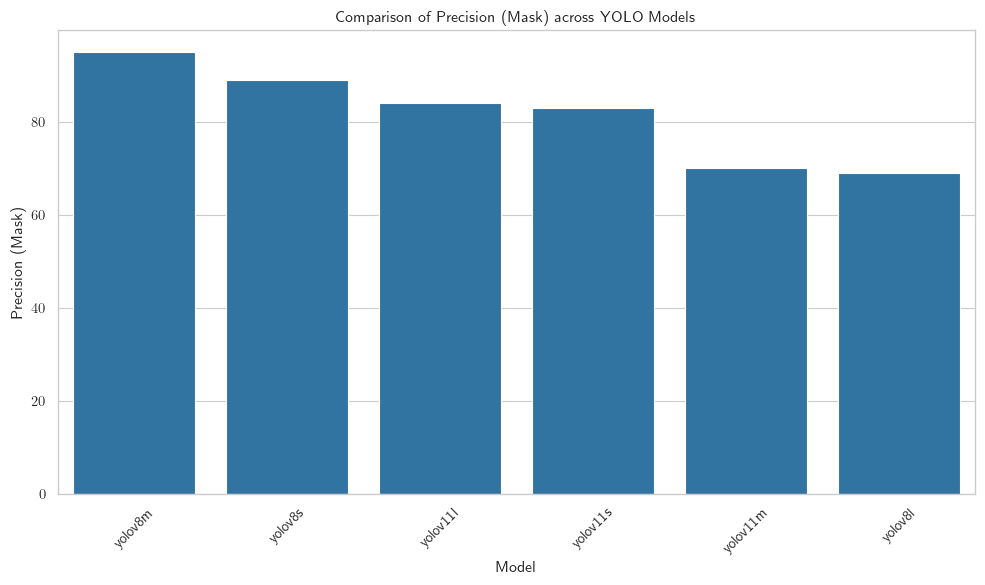

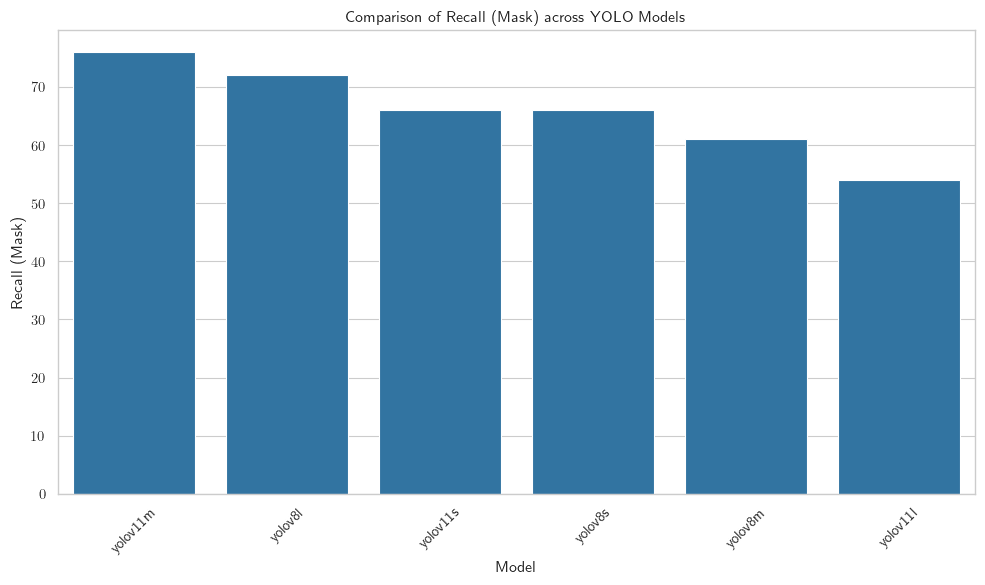

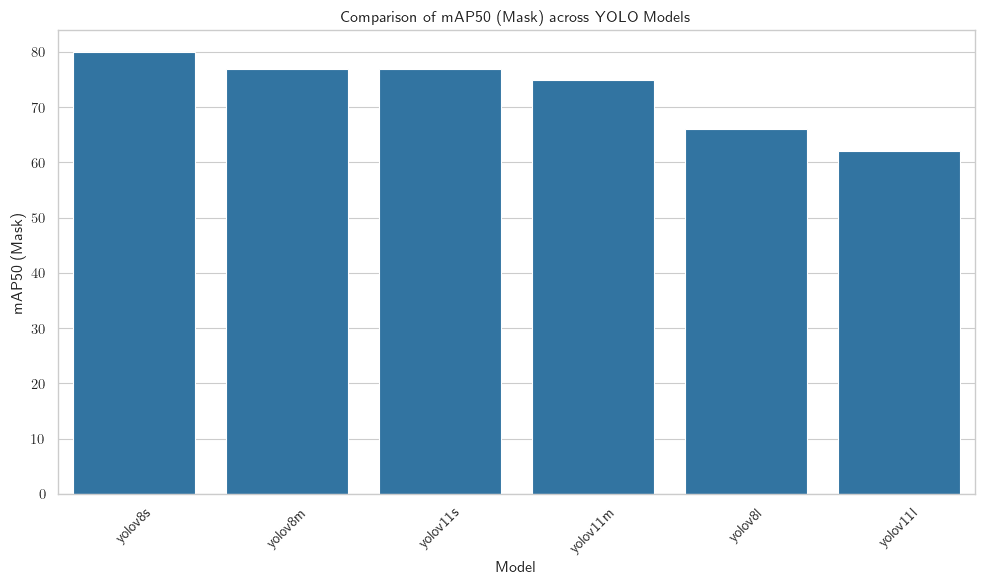

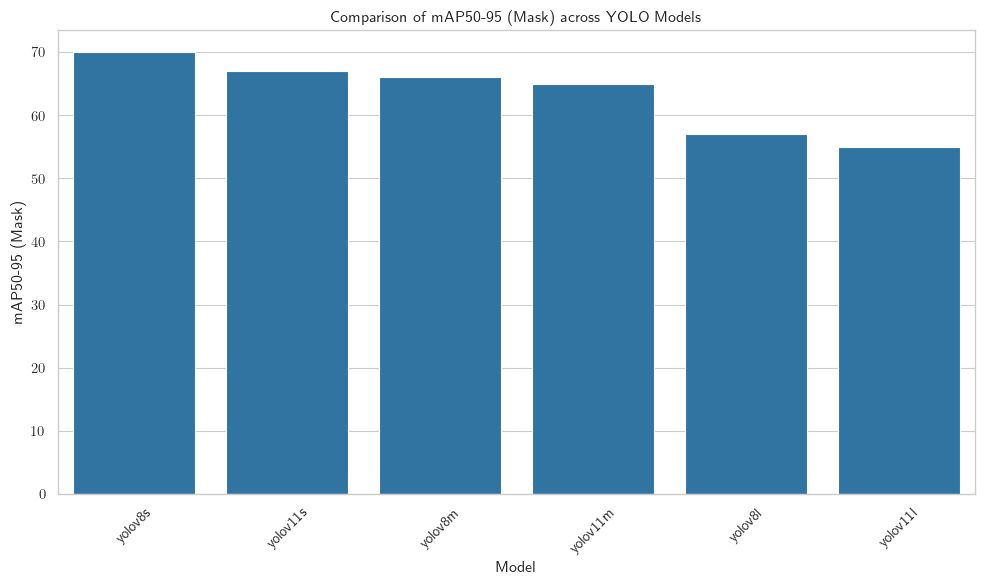

data aug


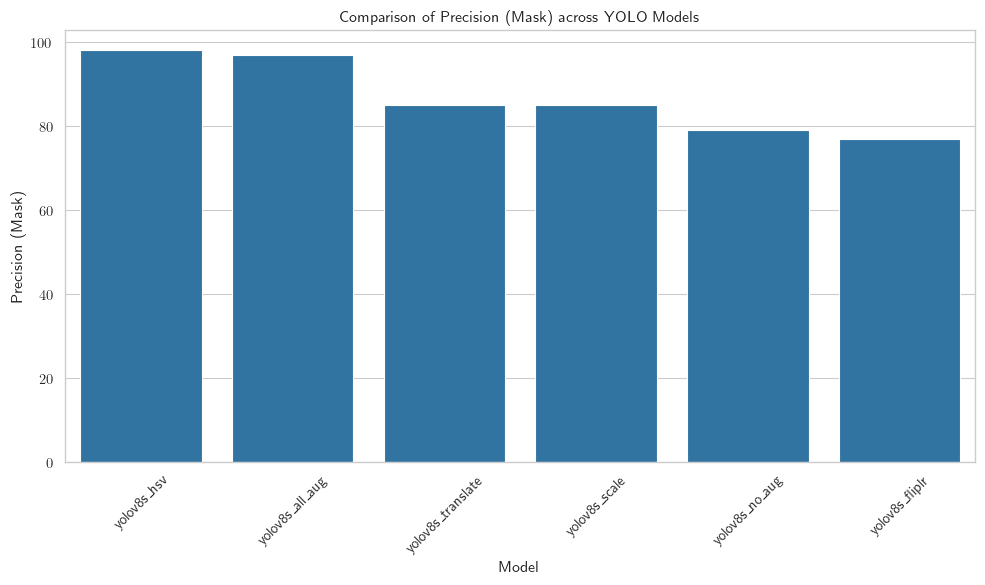

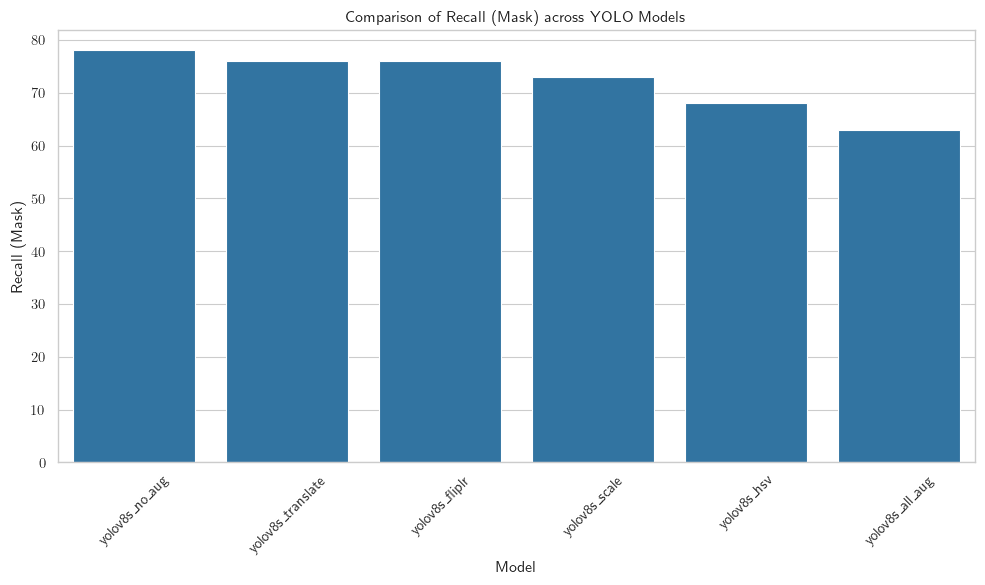

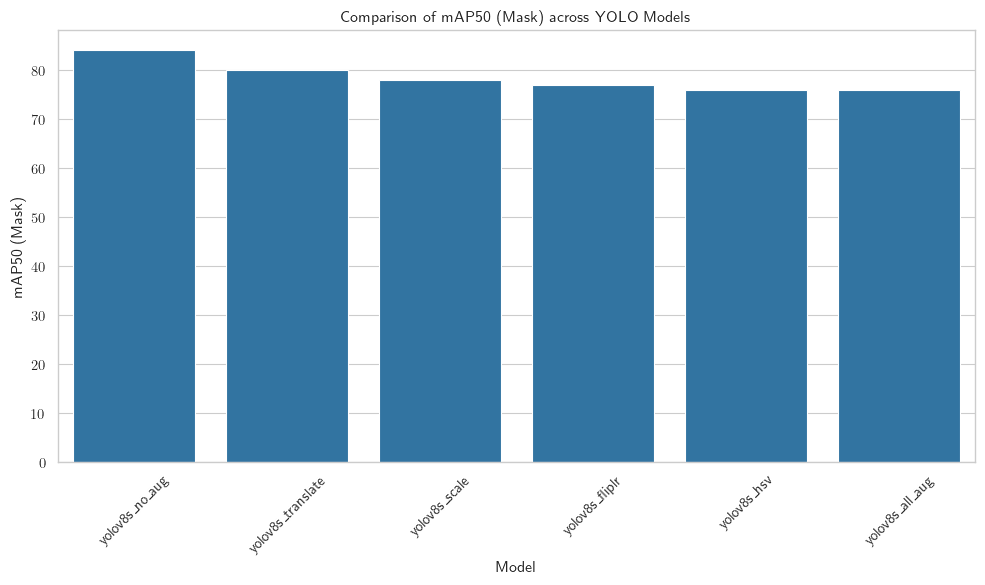

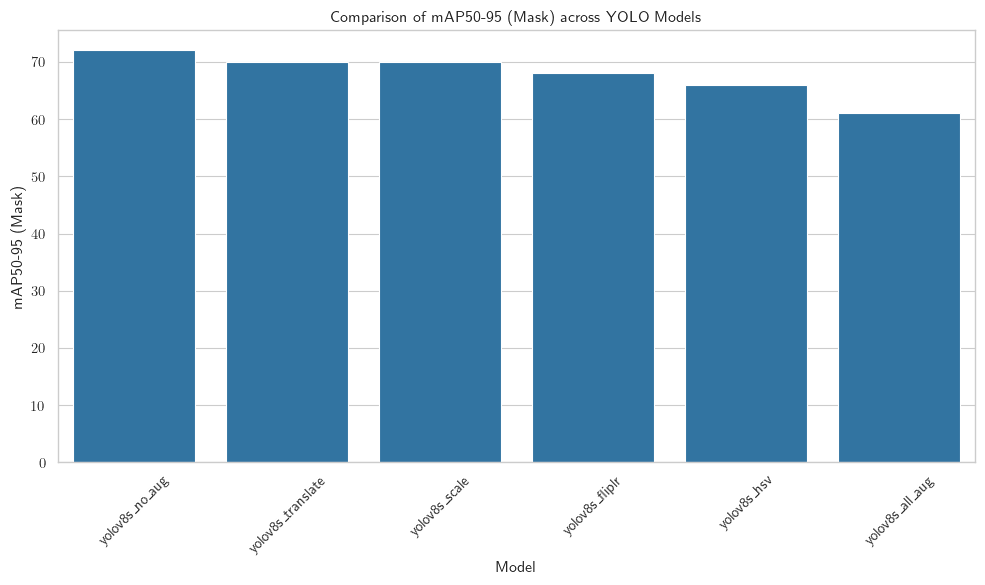

In [38]:
plot_metric_bar(df, metric="Precision (Mask)", data_aug_flag=False, sort_by_metric=True)
plot_metric_bar(df, metric="Recall (Mask)", data_aug_flag=False, sort_by_metric=True)
plot_metric_bar(df, metric="mAP50 (Mask)", data_aug_flag=False, sort_by_metric=True)
plot_metric_bar(df, metric="mAP50-95 (Mask)", data_aug_flag=False, sort_by_metric=True)
print("data aug")
plot_metric_bar(df, metric="Precision (Mask)", data_aug_flag=True, sort_by_metric=True)
plot_metric_bar(df, metric="Recall (Mask)", data_aug_flag=True, sort_by_metric=True)
plot_metric_bar(df, metric="mAP50 (Mask)", data_aug_flag=True, sort_by_metric=True)
plot_metric_bar(df, metric="mAP50-95 (Mask)", data_aug_flag=True, sort_by_metric=True)

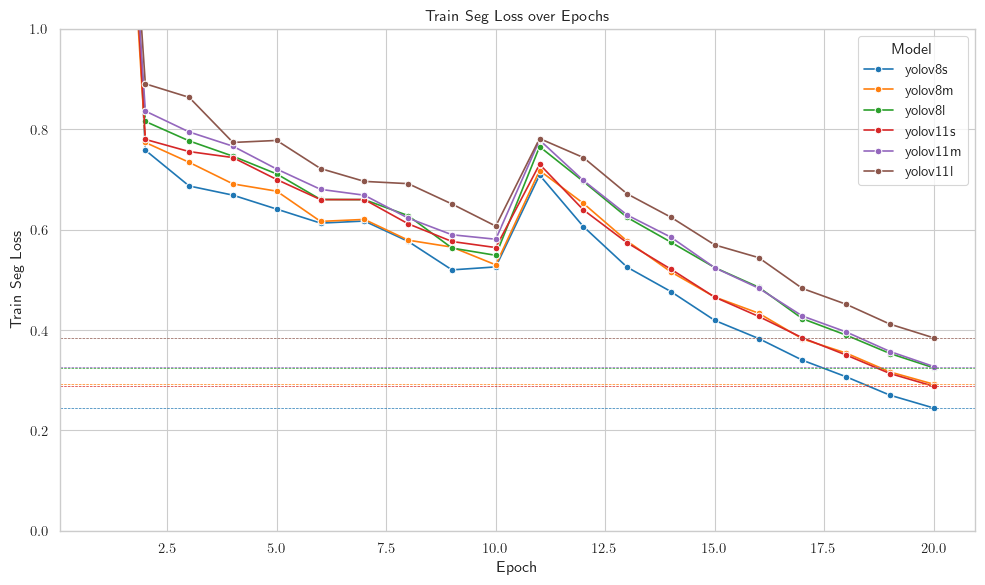

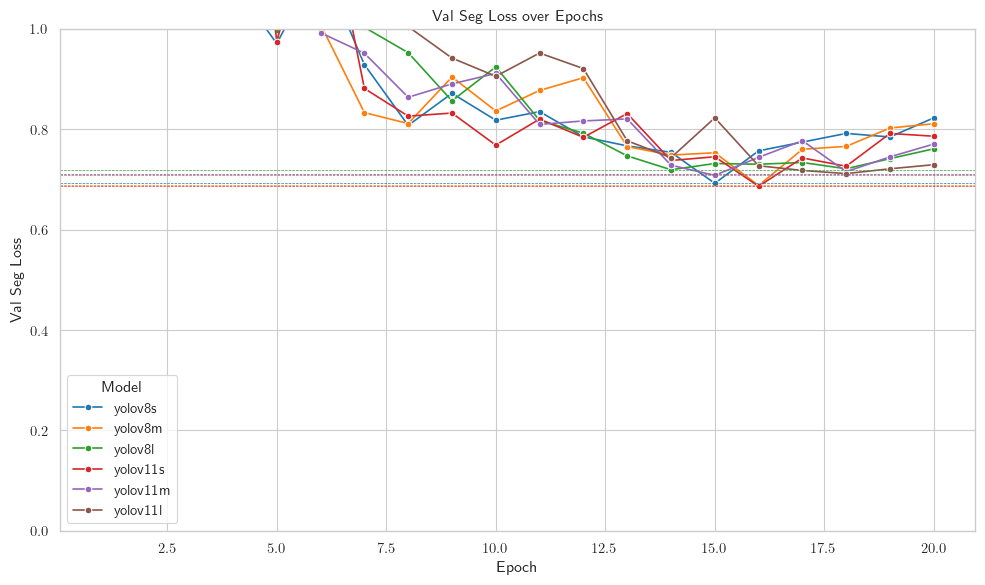

data aug


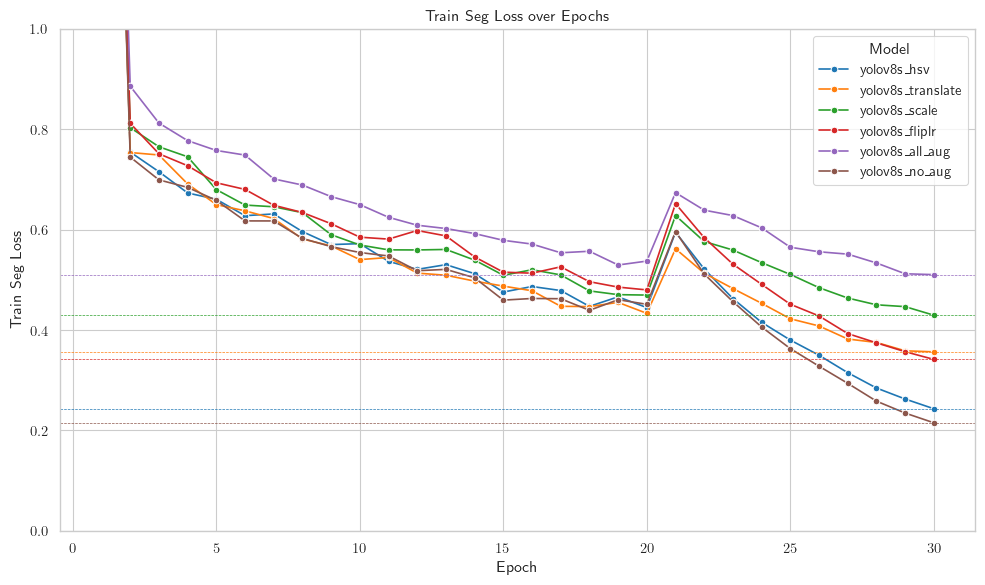

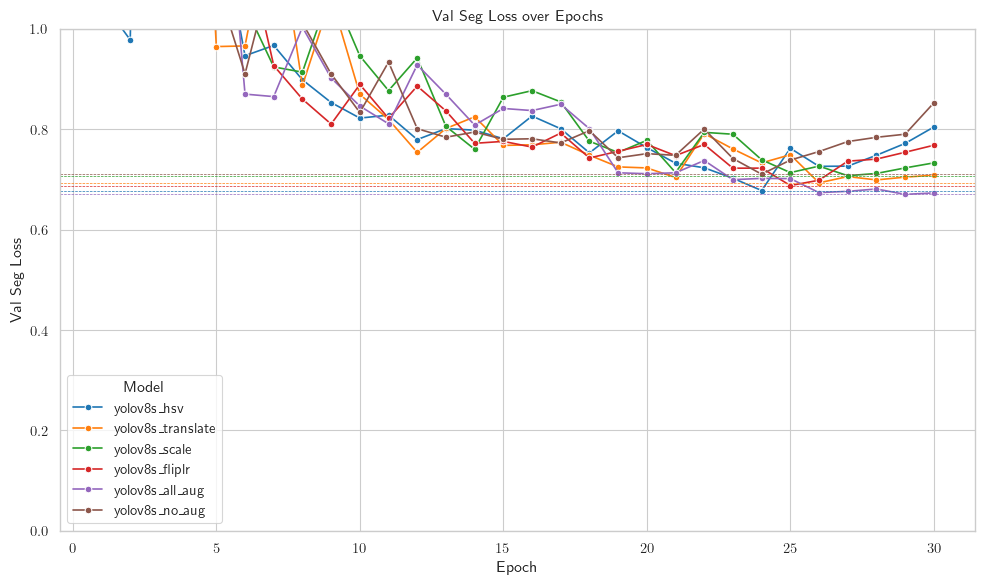

In [39]:
plot_loss_curve(df, loss_column="Train Seg Loss", data_aug_flag=False)
plot_loss_curve(df, loss_column="Val Seg Loss", data_aug_flag=False)
print("data aug")
plot_loss_curve(df, loss_column="Train Seg Loss", data_aug_flag=True)
plot_loss_curve(df, loss_column="Val Seg Loss", data_aug_flag=True)

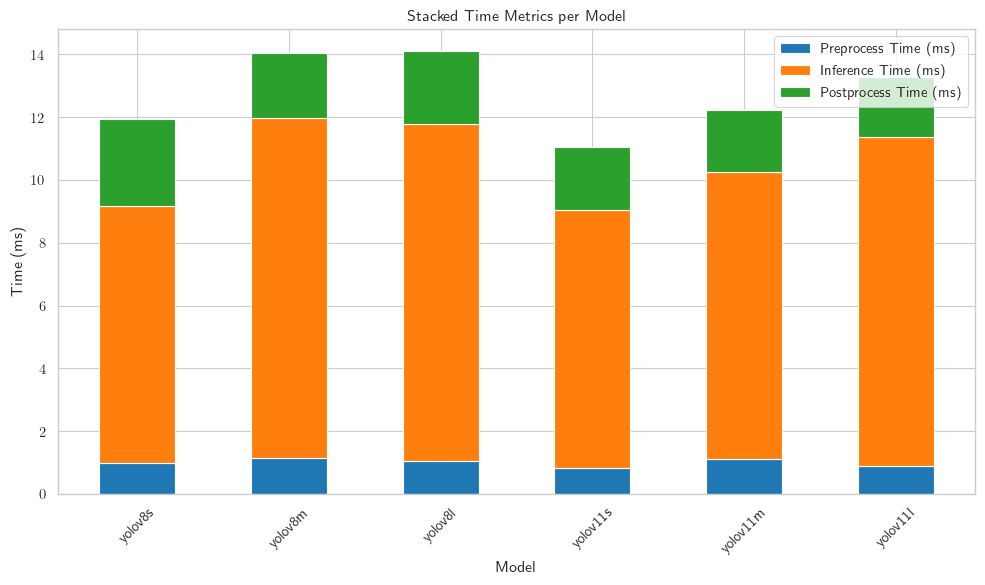

data aug


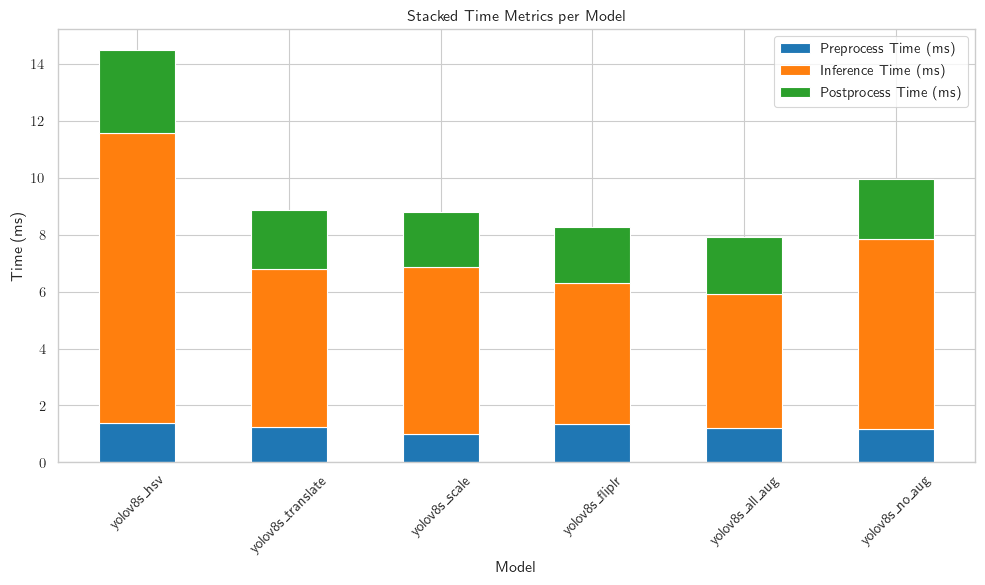

In [40]:
plot_stacked_times(df, data_aug_flag=False)
print("data aug")
plot_stacked_times(df, data_aug_flag=True)